<a href="https://colab.research.google.com/github/alfa7g7/Fundamentos-analitica-II/blob/main/Clase%201/Ejercicio%20en%20clase.-20240802/fundamentos_de_anal%C3%ADtica_clase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Carga de paquetes**

In [2]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (Ocupados13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [3]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)

data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(220, 4)


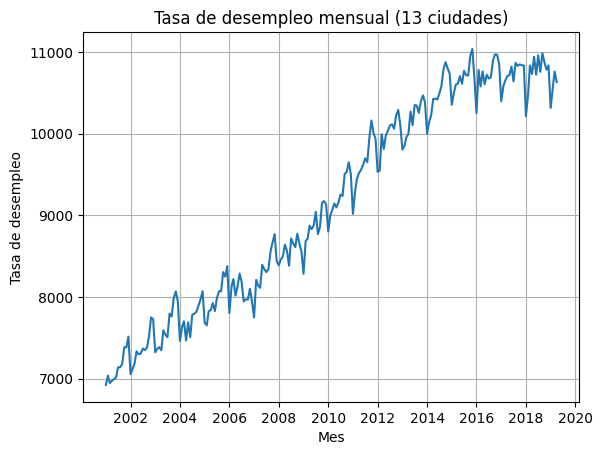

In [4]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

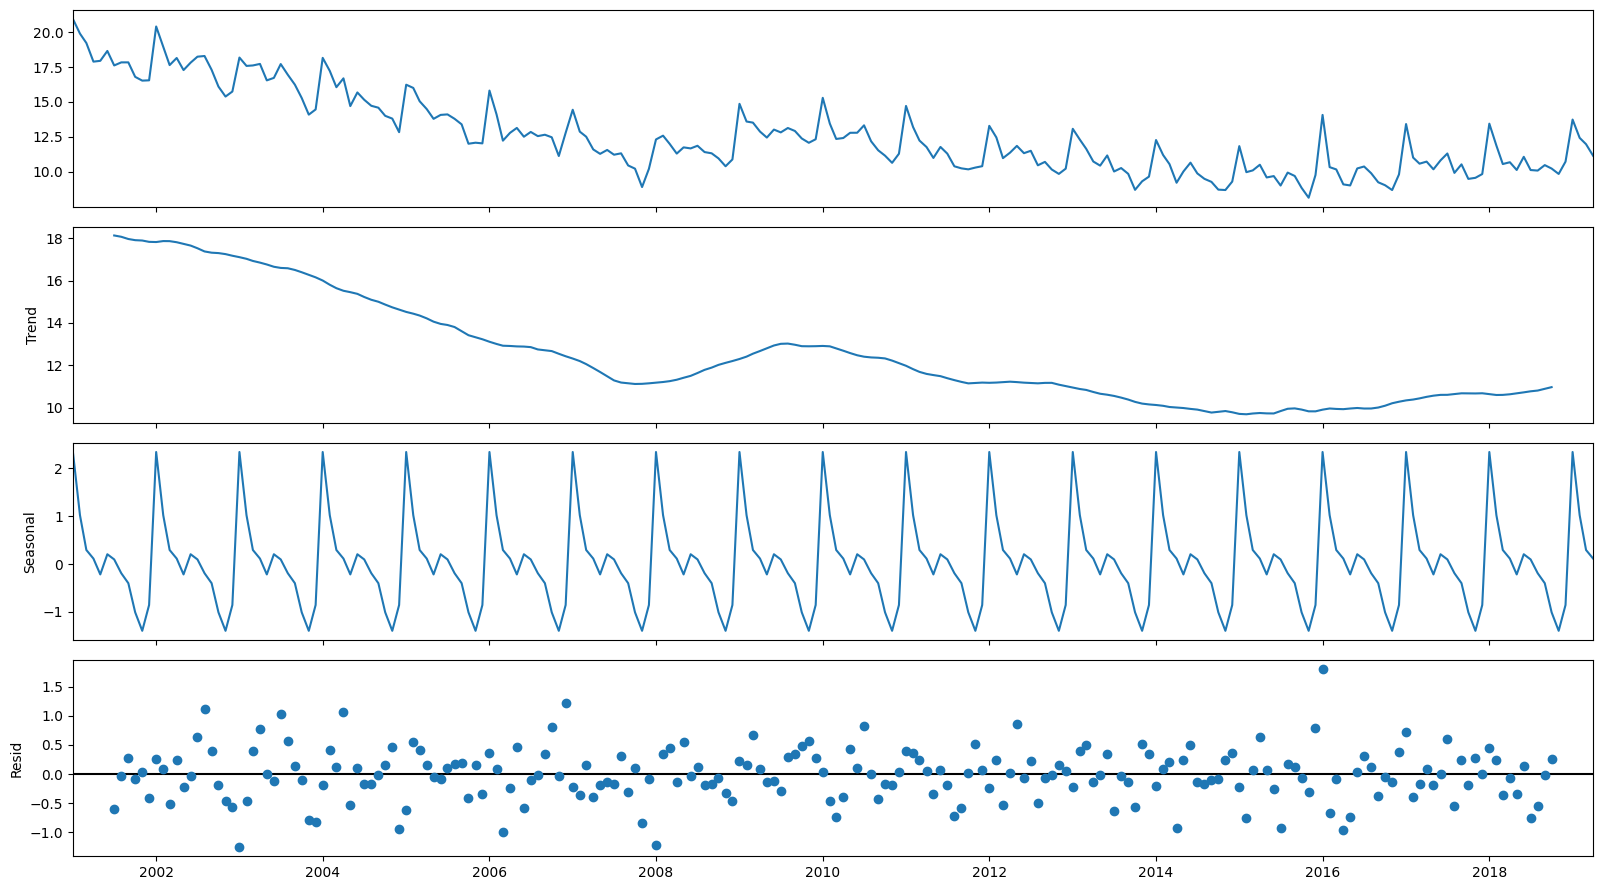

In [5]:
td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [6]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01    2.341068
2001-02-01    1.020286
2001-03-01    0.293373
2001-04-01    0.113895
2001-05-01   -0.217028
                ...   
2018-12-01   -0.856036
2019-01-01    2.341068
2019-02-01    1.020286
2019-03-01    0.293373
2019-04-01    0.113895
Name: seasonal, Length: 220, dtype: float64

In [7]:
td_componentes.trend

mes
2001-01-01   NaN
2001-02-01   NaN
2001-03-01   NaN
2001-04-01   NaN
2001-05-01   NaN
              ..
2018-12-01   NaN
2019-01-01   NaN
2019-02-01   NaN
2019-03-01   NaN
2019-04-01   NaN
Name: trend, Length: 220, dtype: float64

In [8]:
td_componentes.resid

mes
2001-01-01   NaN
2001-02-01   NaN
2001-03-01   NaN
2001-04-01   NaN
2001-05-01   NaN
              ..
2018-12-01   NaN
2019-01-01   NaN
2019-02-01   NaN
2019-03-01   NaN
2019-04-01   NaN
Name: resid, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

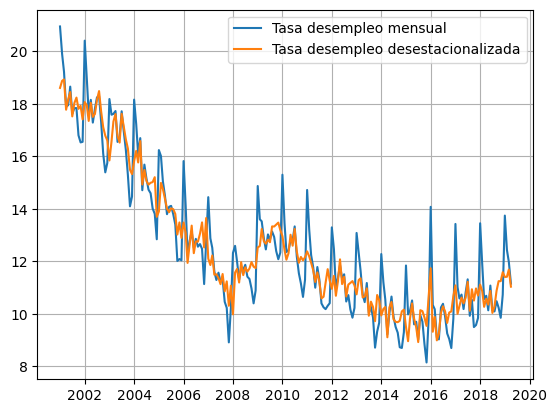

In [9]:
td_desestacionalizada = data["TD_13ciudades"]-td_componentes.seasonal

plt.plot(data[["TD_13ciudades"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

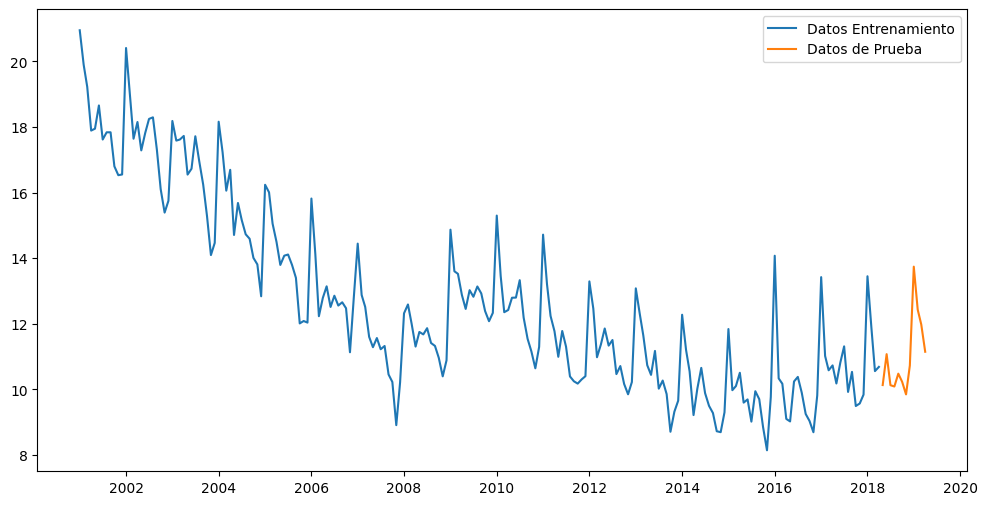

In [10]:
train_len = 208
train_td = data[["TD_13ciudades"]][:train_len]
test_td = data[["TD_13ciudades"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [11]:
train_td

,TD_13ciudades
mes,
2001-01-01,20.946380
2001-02-01,19.894213
2001-03-01,19.221565
2001-04-01,17.888575
2001-05-01,17.945654
...,...
2017-12-01,9.837395
2018-01-01,13.446245
2018-02-01,11.874973


In [12]:
test_td

,TD_13ciudades
mes,
2018-05-01,10.129211
2018-06-01,11.071347
2018-07-01,10.125100
2018-08-01,10.085244
2018-09-01,10.476567
2018-10-01,10.230811
2018-11-01,9.844539
2018-12-01,10.725865
2019-01-01,13.739328


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [13]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [14]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [15]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [16]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [17]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [18]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

1.1781369446057537 1.149344676431958 1.167290983502916 1.1536277219669278


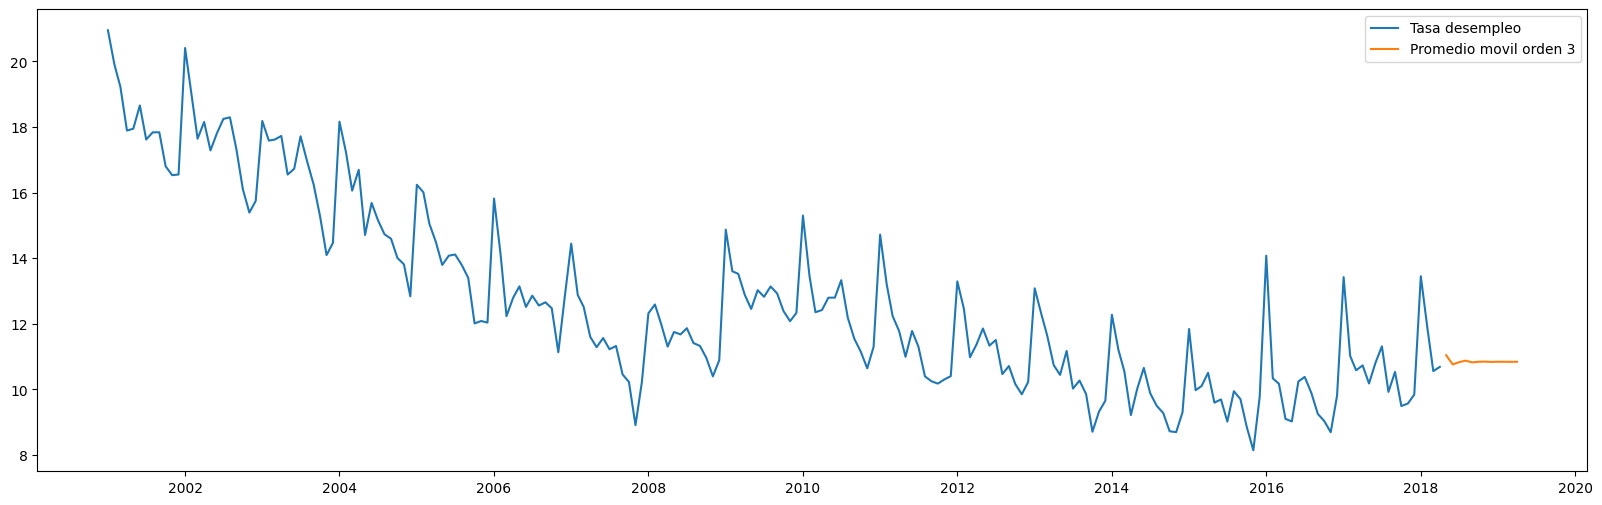

In [19]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [20]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add")#,trend="add",seasonal="mul" ) error: es el alfa adictivo o multiplicativo
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast  lower_95   upper_95
2018-05-01       10.959788  8.650409  13.269166
2018-06-01       10.959788  8.505554  13.414022
2018-07-01       10.959788  8.368785  13.550791
2018-08-01       10.959788  8.238882  13.680694
2018-09-01       10.959788  8.114904  13.804672
2018-10-01       10.959788  7.996108  13.923468
2018-11-01       10.959788  7.881894  14.037682
2018-12-01       10.959788  7.771769  14.147807
2019-01-01       10.959788  7.665323  14.254253
2019-02-01       10.959788  7.562210  14.357366
2019-03-01       10.959788  7.462136  14.457440
2019-04-01       10.959788  7.364847  14.554729


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


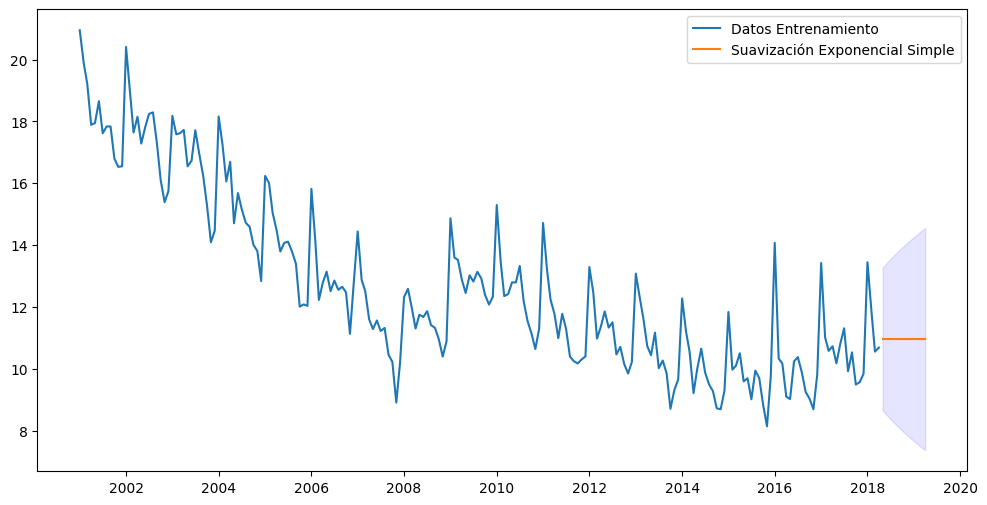

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.3596639.Y el RMSE en la muestra de evaluación es 1.12

In [22]:
ets_result.alpha

0.35969977150507815

In [23]:
rmse = np.sqrt(mean_squared_error(test_Ocupados,point_forecast ))
print(rmse)

1.124421772293525


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [24]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast  lower_95   upper_95
2018-05-01       10.660582  8.644564  12.772056
2018-06-01       10.632885  8.623138  12.755030
2018-07-01       10.605260  8.285610  12.929017
2018-08-01       10.577707  8.497012  12.835411
2018-09-01       10.550225  8.344016  12.918597
2018-10-01       10.522815  8.397966  12.737282
2018-11-01       10.495476  8.375743  12.935077
2018-12-01       10.468208  8.307826  12.609277
2019-01-01       10.441010  8.144914  12.519896
2019-02-01       10.413884  8.162686  12.689690
2019-03-01       10.386828  8.121818  12.804956
2019-04-01       10.359842  8.029032  12.770235


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


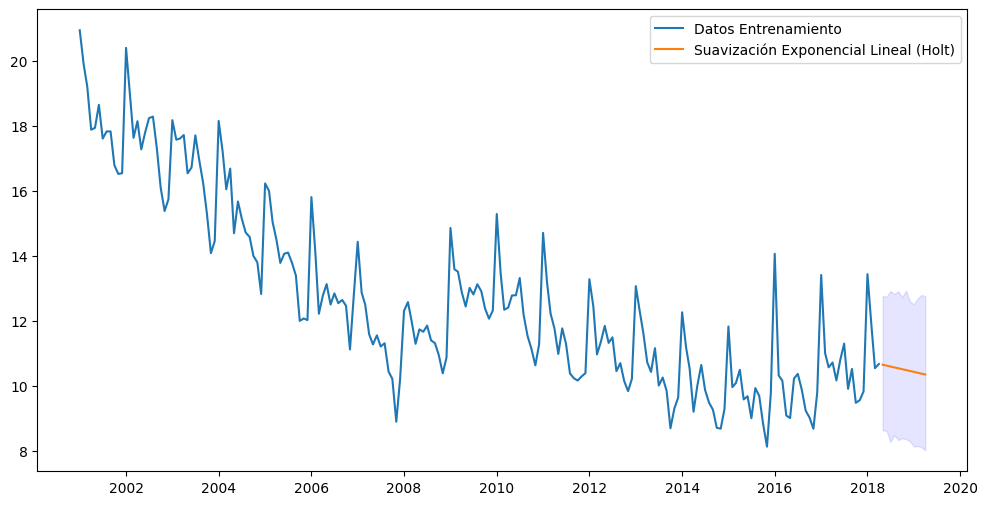

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.17153975893378887 y el β estimado es 1.7153975893378887$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [26]:
print(ets_result.alpha,ets_result.beta)

0.1715370923131306 1.7153709231313062e-05


In [27]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

1.2780066450538032


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [28]:
# Build model
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast   lower_95   upper_95
2018-05-01       10.297343   9.251531  11.343154
2018-06-01       10.674326   9.532336  11.816315
2018-07-01       10.565102   9.334411  11.795793
2018-08-01       10.226632   8.913201  11.540064
2018-09-01        9.946453   8.555177  11.337728
2018-10-01        9.282709   7.817706  10.747712
2018-11-01        8.875229   7.340021  10.410437
2018-12-01        9.376622   7.774270  10.978975
2019-01-01       12.534227  10.867420  14.201034
2019-02-01       11.193090   9.464217  12.921963
2019-03-01       10.434280   8.645482  12.223078
2019-04-01       10.158436   8.311645  12.005227


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


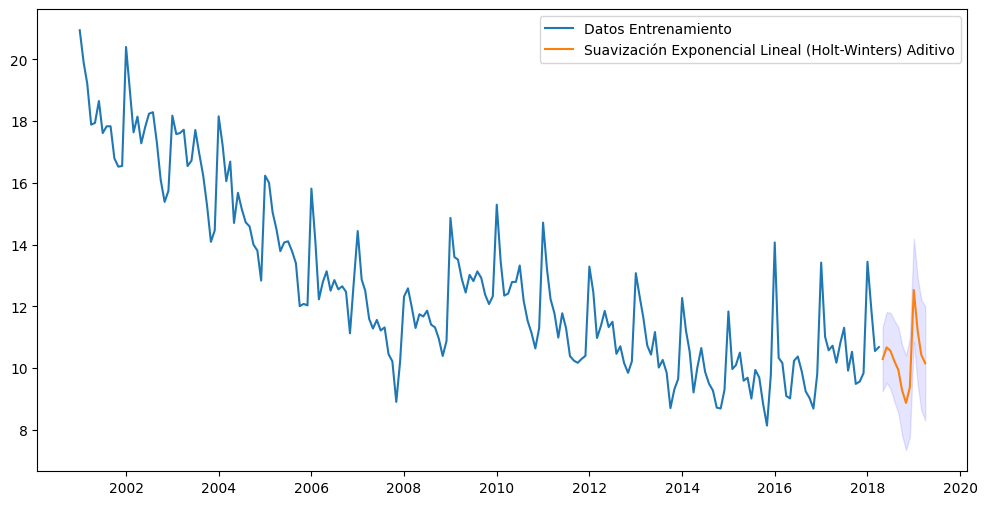

In [29]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [30]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.43857579870448893 4.3857579870448896e-05 5.614242012955111e-05


In [31]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

0.9425697279485371


In [32]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast   lower_95   upper_95
2018-05-01       10.433036   9.197344  11.537073
2018-06-01       10.981856   9.735341  12.327107
2018-07-01       10.779516   9.491606  12.120224
2018-08-01       10.380956   8.963437  11.714527
2018-09-01       10.300534   8.944955  11.857514
2018-10-01        9.708898   8.107028  11.121309
2018-11-01        9.565507   7.989474  11.057469
2018-12-01       10.265135   8.531248  11.833313
2019-01-01       13.399531  11.269114  15.398819
2019-02-01       11.447407   9.498024  13.373376
2019-03-01       10.843306   8.995846  12.690399
2019-04-01       10.618172   8.602718  12.557181


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


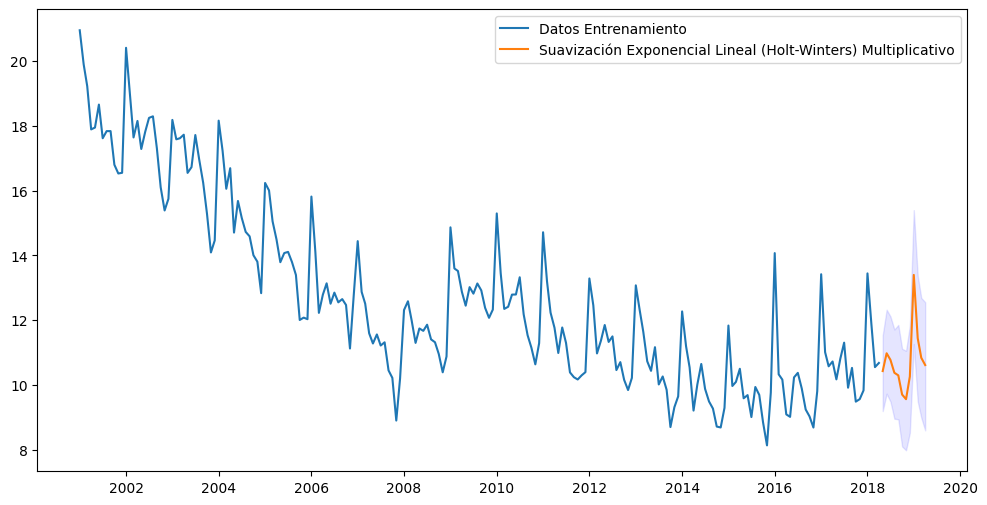

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [34]:
print(ets_result.alpha,ets_result.gamma)

0.4314985227050782 0.1609709018402775


In [35]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

0.5659175481344269


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

Limitacion> a medida que se aleja del tiempo pierde precision

### 5.1 Definición del cinjunto de datos

In [36]:
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403


### 5.2 Graficamos la variable de Ocupados

(220, 4)


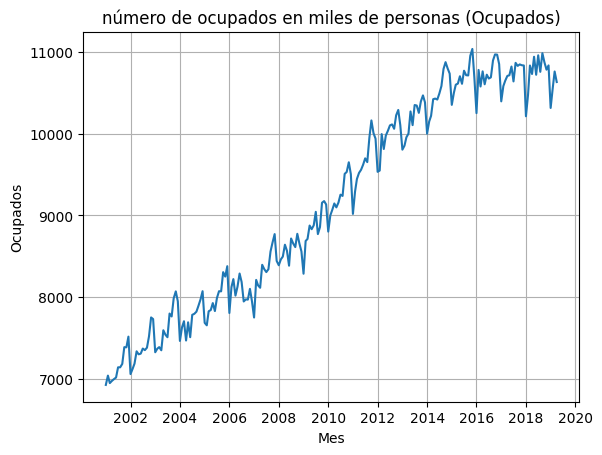

In [38]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos

plt.title("número de ocupados en miles de personas (Ocupados)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

### 5.3 Encontramos los componentes de la serie de tiempo

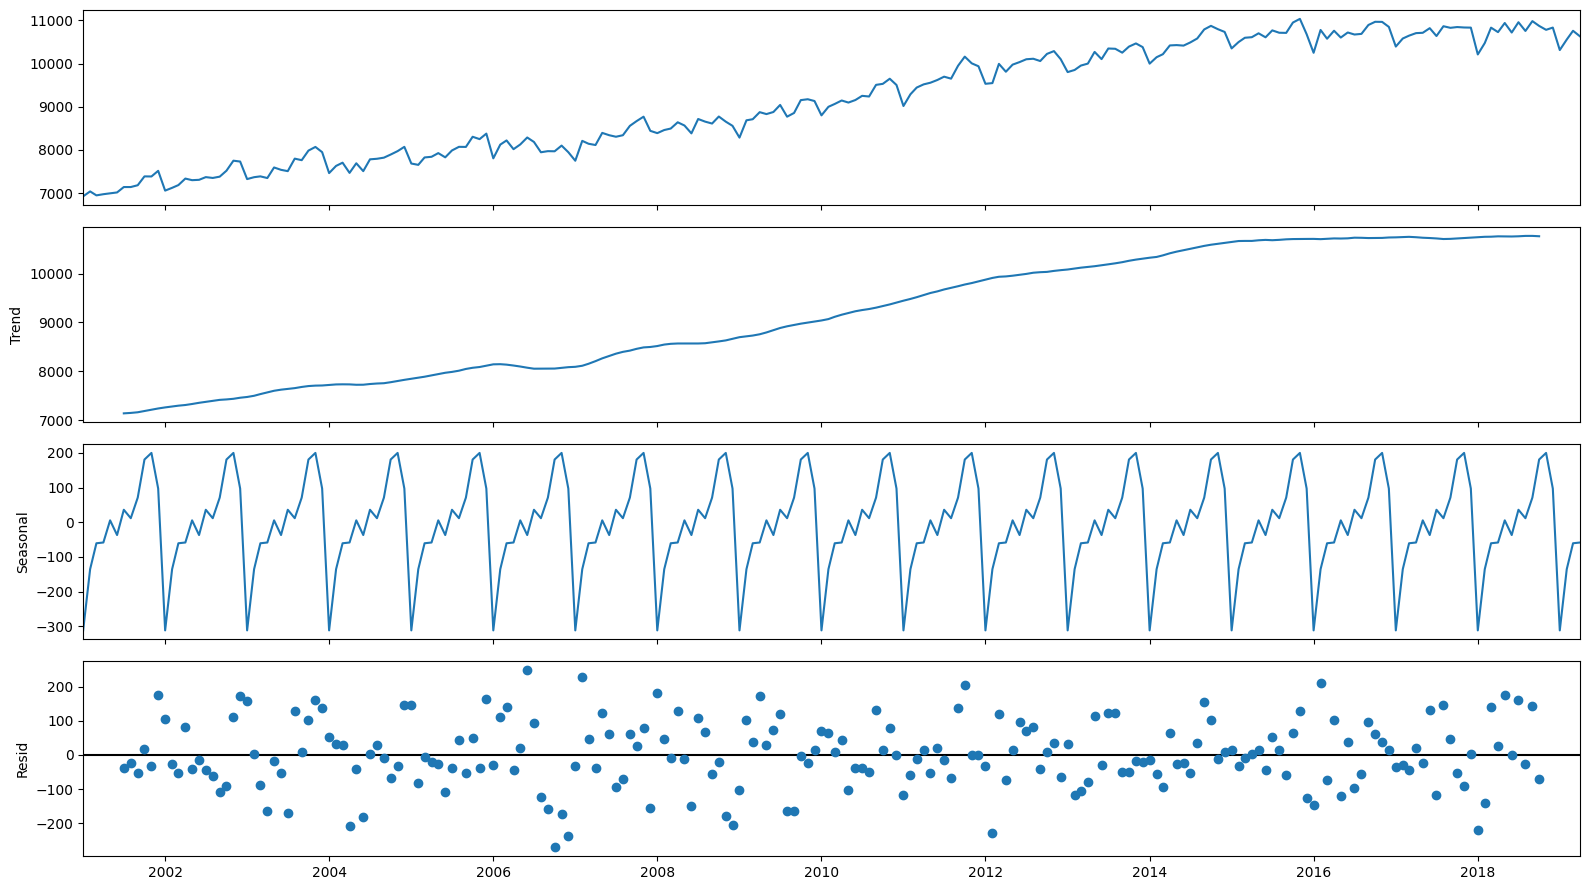

In [47]:
ocupados_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")#"mul")
fig = ocupados_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Extrayendo cada elemento de la descomposición de la serie

In [48]:
ocupados_componentes.seasonal
#ocupados_componentes.trend
#ocupados_componentes.resid

mes
2001-01-01   -311.454885
2001-02-01   -135.216366
2001-03-01    -60.470657
2001-04-01    -58.270721
2001-05-01      5.551095
                 ...    
2018-12-01     97.140345
2019-01-01   -311.454885
2019-02-01   -135.216366
2019-03-01    -60.470657
2019-04-01    -58.270721
Name: seasonal, Length: 220, dtype: float64

Verifiquemos si mi estacionalidad es constante o proporcional:

In [49]:
from statsmodels.tsa.stattools import adfuller

# Supongamos que 'data[["Ocupados"]]' es tu serie temporal
dftest = adfuller(data[["Ocupados"]], autolag='AIC')

# Resultados de la prueba
dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba', 'Valor p', '#Lags utilizados', 'Número de observaciones'])
print('Resultados de la Prueba de Dickey-Fuller:')
print(dfoutput)


Resultados de la Prueba de Dickey-Fuller:
Estadístico de prueba       -1.418807
Valor p                      0.573228
#Lags utilizados            14.000000
Número de observaciones    205.000000
dtype: float64


Debido al valor p mayor a 0.05, no rechazamos que no sea estacionaria. No nos es claro si debemos descompenerla aditivamente o multiplicativamentes haciendo la prueba de Dickey-Fuller las 2 versiones nos dan valores que no rechazaían el supuesto.
Aquí profe nos podría dar una retroalimentación por favor y proseguiremos en aditivio

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

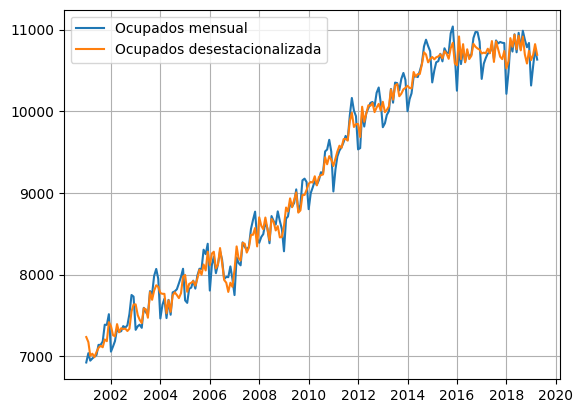

In [53]:
Ocupados_desestacionalizada = data["Ocupados"]-ocupados_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(Ocupados_desestacionalizada,label="Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()

### 5.4 Pronosticando metodos de suavización

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

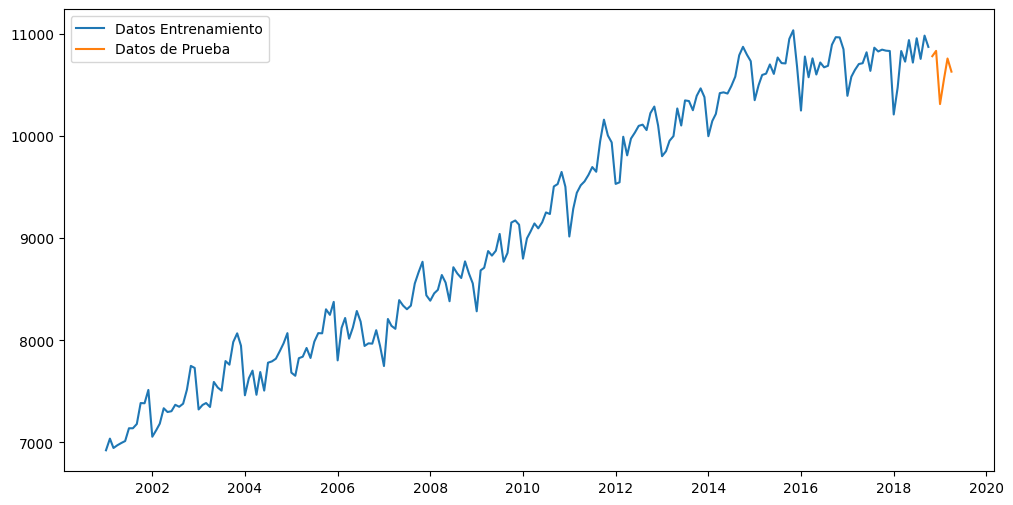

In [93]:
train_len = 214
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(test_Ocupados,label="Datos de Prueba")
plt.legend()
plt.show()

In [94]:
train_Ocupados

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782


In [95]:
test_Ocupados

,Ocupados
mes,
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


#### 5.4.1 Promedio movil

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [96]:
## Considerando el dato actual
ma_2= train_Ocupados.rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.rolling(5,min_periods=2).mean()
ma_6= train_Ocupados.rolling(6,min_periods=2).mean()

In [97]:
## Sin considerar el dato actual
ma_2= train_Ocupados.shift().rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.shift().rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.shift().rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.shift().rolling(5,min_periods=2).mean()
ma_6= train_Ocupados.shift().rolling(6,min_periods=2).mean()

In [98]:
def fore_ma(datos,w,h): #w es la ventana del promedio para hacer el pronostico (10,15,20,25,30) w=2 (10 con 15, 15 con 20, 20 con 25) w=3 (10 con 15 con 20, )..., h el num de pronosticos hacia adelante
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [99]:
ma_2_f= fore_ma(train_Ocupados,2,6) # duda: si h es quien me mide el pronostico 6 meses??
ma_3_f= fore_ma(train_Ocupados,3,6)
ma_4_f= fore_ma(train_Ocupados,4,6)
ma_5_f= fore_ma(train_Ocupados,5,6)
ma_6_f= fore_ma(train_Ocupados,6,6)

In [100]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_Ocupados,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_Ocupados,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_Ocupados,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_Ocupados,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_Ocupados,ma_6_f ))

In [101]:
print( rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5, rmse_ma_6)

319.1849777906289 298.3770292088787 305.34686253059 291.01606293356485 291.5713004314995


De acuerdo a estos resultados la mejor opcion sería el rmse_ma_5 quien tiene un valor de 291.01606293356485

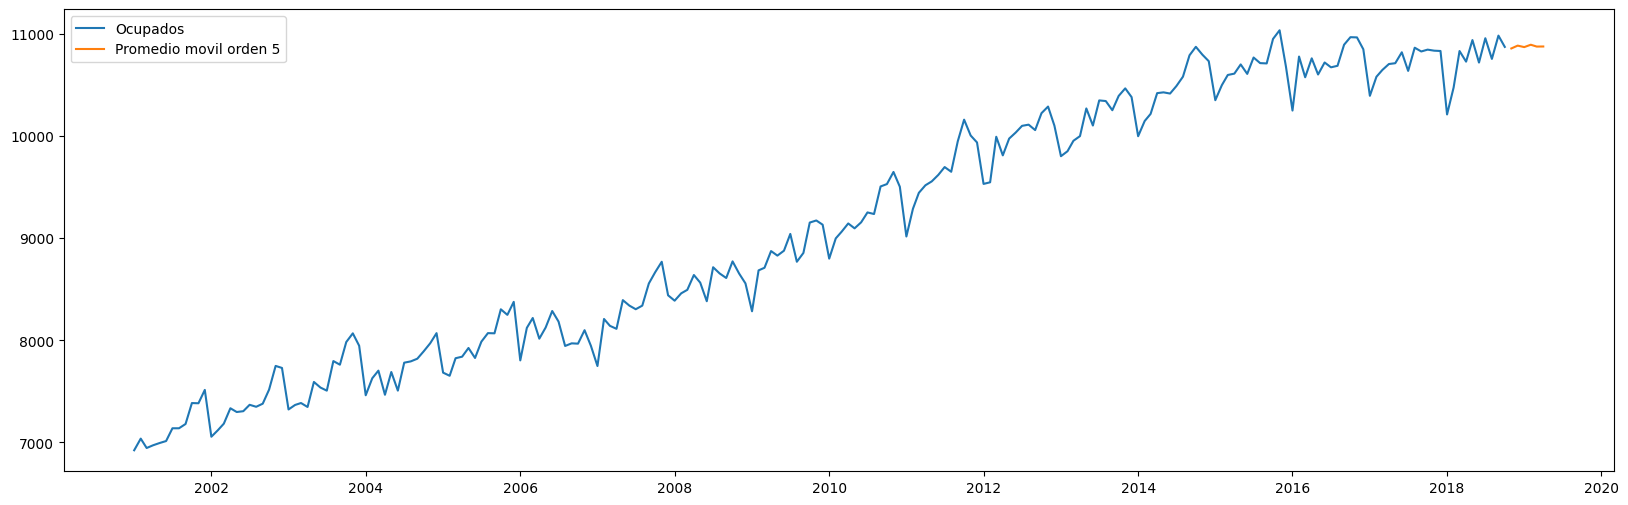

In [114]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_Ocupados,label="Ocupados")
plt.plot(ma_5_f,label="Promedio movil orden 5")
plt.legend()
plt.show()

#### 5.4.2 Suavización exponencial simple

In [115]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add")#,trend="add",seasonal="mul" ) error: es el alfa adictivo o multiplicativo
ets_result = ets_model.fit()

# Forecast
point_forecast=ets_result.forecast(6) # En forecast(horizon), defino la cantidad de tiempo que voy a predecir en meses en este caso 6

# Confidence intervals
ci = ets_result.get_prediction(start = point_forecast.index[0], end = point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    10890.815856  10535.182689  11246.449022
2018-12-01    10890.815856  10469.673459  11311.958252
2019-01-01    10890.815856  10413.063946  11368.567765
2019-02-01    10890.815856  10362.485602  11419.146109
2019-03-01    10890.815856  10316.343206  11465.288506
2019-04-01    10890.815856  10273.641006  11507.990705


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


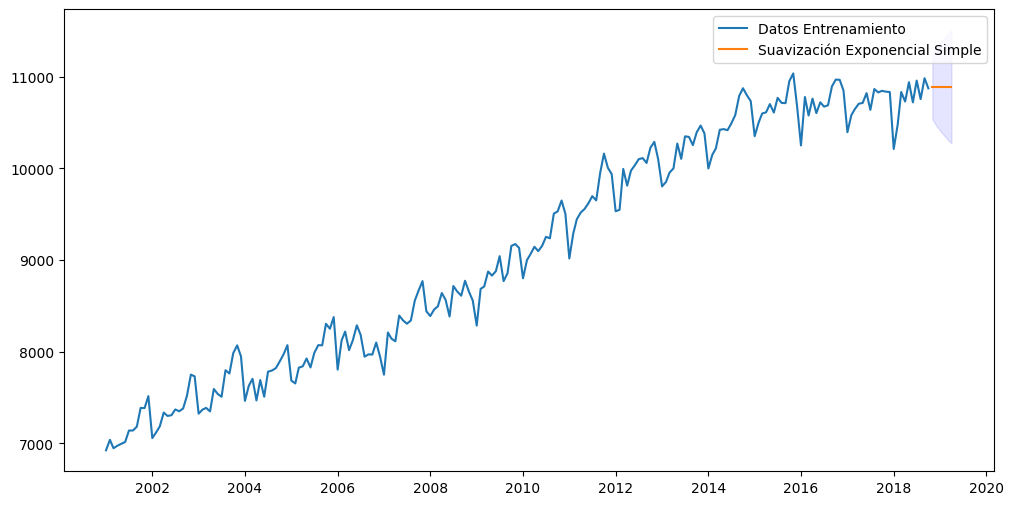

In [116]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [117]:
ets_result.alpha

0.6343030045478203

In [118]:
rmse = np.sqrt(mean_squared_error(test_Ocupados,point_forecast ))
print(rmse)

300.4290298412983


En esta caso el α estimado es 0.6343030045478203 y el RMSE en la muestra de evaluación es 300.4290298412983

#### 5.4.3 Suavizacion Exponencial Lineal (Holt)

In [109]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

# forecast
point_forecast=ets_result.forecast(6)

# Confidence Intervals
ci = ets_result.get_prediction(start = point_forecast.index[0], end = point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-11-01    10932.699235  10530.387913  11380.862448
2018-12-01    10956.943735  10488.420520  11444.420465
2019-01-01    10981.242000  10455.504018  11519.269303
2019-02-01    11005.594150  10446.247989  11597.195802
2019-03-01    11030.000303  10421.060235  11666.378687
2019-04-01    11054.460579  10425.903627  11756.995127


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


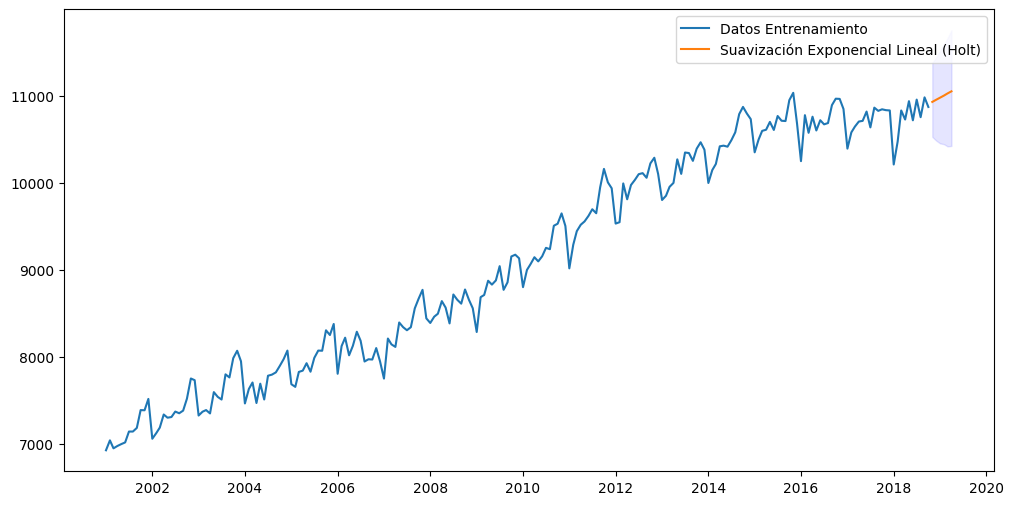

In [110]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [111]:
print(ets_result.alpha,ets_result.beta)

0.5483137388095899 5.483137388095899e-05


In [112]:
rmse_holt = np.sqrt(mean_squared_error(test_Ocupados,preds_holt['Point_forecast']))
print(rmse_holt)

394.3490861859369


En esta caso el α estimado es 0.5483137388095899 y el β estimado es 5.483137388095899e-05 

El RMSE en la muestra de evaluación es 394.3490861859369

#### 5.4.4 Suavizacion Exponencial Lineal de Winters (Holt-Winters)

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error with parameters error=add, trend=add, seasonal=None: 'ETSResults' object has no attribute 'gamma'
Error with parameters error=add, trend=mul, seasonal=None: 'ETSResults' object has no attribute 'gamma'


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error with parameters error=add, trend=None, seasonal=add: 'ETSResults' object has no attribute 'beta'
Error with parameters error=add, trend=None, seasonal=mul: 'ETSResults' object has no attribute 'beta'
Error with parameters error=add, trend=None, seasonal=None: 'ETSResults' object has no attribute 'beta'


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473:

Error with parameters error=mul, trend=add, seasonal=None: 'ETSResults' object has no attribute 'gamma'


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error with parameters error=mul, trend=mul, seasonal=None: 'ETSResults' object has no attribute 'gamma'
Error with parameters error=mul, trend=None, seasonal=add: 'ETSResults' object has no attribute 'beta'
Error with parameters error=mul, trend=None, seasonal=mul: 'ETSResults' object has no attribute 'beta'
Error with parameters error=mul, trend=None, seasonal=None: 'ETSResults' object has no attribute 'beta'
Error with parameters error=None, trend=add, seasonal=add: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=add, seasonal=mul: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=add, seasonal=None: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=add: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=mul: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=None: 'NoneType' object is not subscripta

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473:

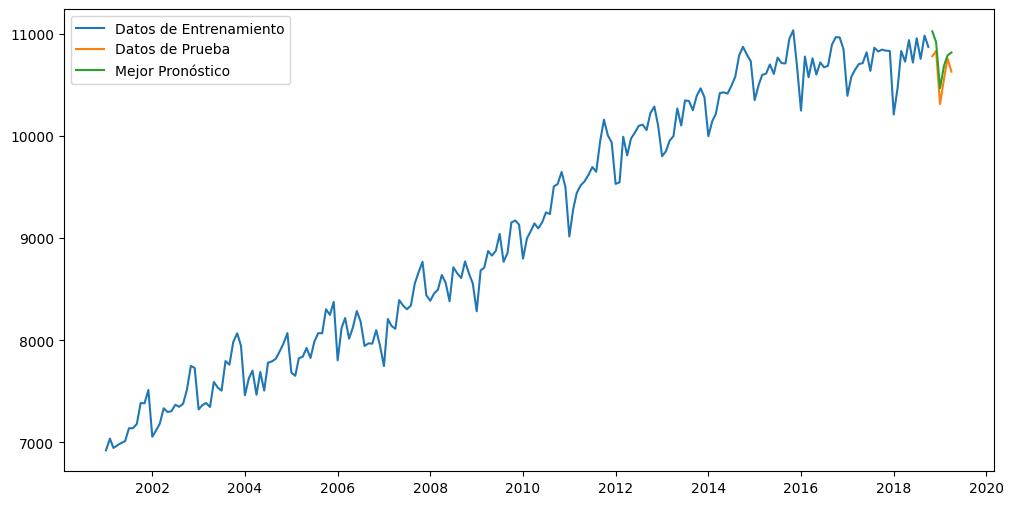

  Error Trend Seasonal     Alpha      Beta     Gamma        RMSE
0   add   add      add  0.339803  0.000034  0.301398  163.595460
1   add   add      mul  0.513366  0.001316  0.000049  156.414786
2   add   mul      add  0.388737  0.000039  0.337249  169.239439
3   add   mul      mul  0.513649  0.000051  0.000049  154.813901
4   mul   add      add  0.500113  0.000050  0.000050  194.567616
5   mul   add      mul  0.550834  0.000331  0.000045  162.249941
6   mul   mul      add  0.306343  0.002577  0.425171  208.687404
7   mul   mul      mul  0.546603  0.000055  0.000045  160.571455


In [121]:
from itertools import product

# Diferentes opciones de parámetros
params_grid = list(product(["add", "mul", None], repeat=3))

# Inicializar variables para guardar el mejor resultado
best_rmse = float('inf')
best_params = None
best_model = None

# Lista para guardar los resultados
results = []

# Ciclo para evaluar cada combinación de parámetros
for error, trend, seasonal in params_grid:
    try:
        # Train model
        ets_model = ETSModel(endog=train_Ocupados["Ocupados"], error=error, trend=trend, seasonal=seasonal)
        ets_result = ets_model.fit()
        
        # Realizar predicciones
        forecast_len = len(test_Ocupados)
        point_forecast = ets_result.forecast(forecast_len)
        
        # Calculo coeficientes y el RMSE
        alpha = ets_result.alpha
        beta = ets_result.beta
        gamma = ets_result.gamma
        rmse = np.sqrt(mean_squared_error(test_Ocupados["Ocupados"], point_forecast))
        results.append((error, trend, seasonal, alpha, beta, gamma, rmse))
        
        # Guardar el mejor modelo
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (error, trend, seasonal)
            best_model = ets_result
            
    except Exception as e:
        # Ignorar combinaciones no válidas
        print(f"Error with parameters error={error}, trend={trend}, seasonal={seasonal}: {e}")

# Mostrar los mejores parámetros y el RMSE
print(f"Best Parameters: error={best_params[0]}, trend={best_params[1]}, seasonal={best_params[2]}")
print(f"Best RMSE: {best_rmse}")

# Graficar el mejor modelo
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados, label="Datos de Entrenamiento")
plt.plot(test_Ocupados, label="Datos de Prueba")
plt.plot(test_Ocupados.index, best_model.forecast(forecast_len), label="Mejor Pronóstico")
plt.legend()
plt.show()

# DataFrame con los resultados
results_df = pd.DataFrame(results, columns=['Error', 'Trend', 'Seasonal', 'Alpha', 'Beta', 'Gamma', 'RMSE'])
print(results_df)


In [67]:
# Build model Aditivo
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

# forecast
point_forecast=ets_result.forecast(6)

# Confidence intervals
ci = ets_result.get_prediction(start = point_forecast.index[0], end = point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2018-05-01    10778.708058  10522.810656  11034.605460
2018-06-01    10842.416984  10571.477782  11113.356185
2018-07-01    10833.186676  10547.995150  11118.378201
2018-08-01    10942.058240  10643.290861  11240.825618
2018-09-01    10997.453135  10685.697988  11309.208282
2018-10-01    11095.814544  10771.589032  11420.040056
2018-11-01    11114.750563  10778.514517  11450.986609
2018-12-01    11011.755005  10663.920619  11359.589391
2019-01-01    10524.718662  10165.658183  10883.779141
2019-02-01    10802.721973  10432.773759  11172.670188
2019-03-01    10952.696353  10572.169716  11333.222989
2019-04-01    10962.090701  10571.269838  11352.911563


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


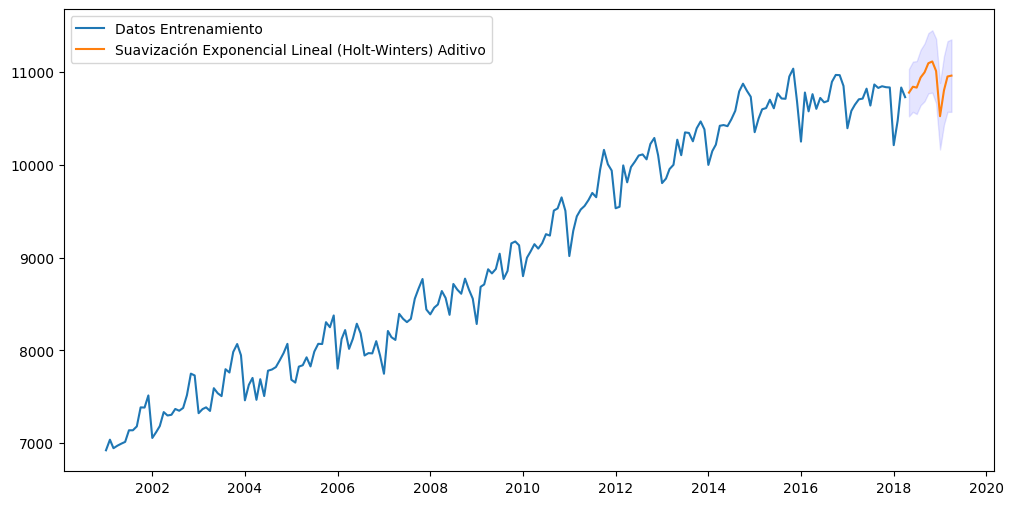

In [68]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [72]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3478392284982235 3.478392284982235e-05 0.3221634443348571


In [73]:
rmse_hw_add = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.45351531012744


En esta caso el α estimado es 0.3478392284982235, el β estimado es 3.478392284982235e-05 y el gamma estimado es 0.3221634443348571 

El RMSE en la muestra de evaluación es 210.45351531012744

In [75]:
# Build model multiplicativo
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="mul",trend="mul",seasonal="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10822.866381  10561.918661  11117.258541
2018-06-01    10803.806769  10507.441019  11110.480096
2018-07-01    10910.545440  10568.375832  11261.743652
2018-08-01    10913.839802  10572.426816  11287.824153
2018-09-01    10991.715755  10603.780900  11412.530850
2018-10-01    11165.578034  10718.825198  11621.680646
2018-11-01    11211.259460  10772.603259  11713.545389
2018-12-01    11118.119500  10626.524470  11622.014203
2019-01-01    10650.688465  10171.083822  11146.362264
2019-02-01    10870.800892  10383.331891  11391.981361
2019-03-01    10965.074602  10439.090417  11531.752308
2019-04-01    10985.918034  10442.384304  11568.433582


C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


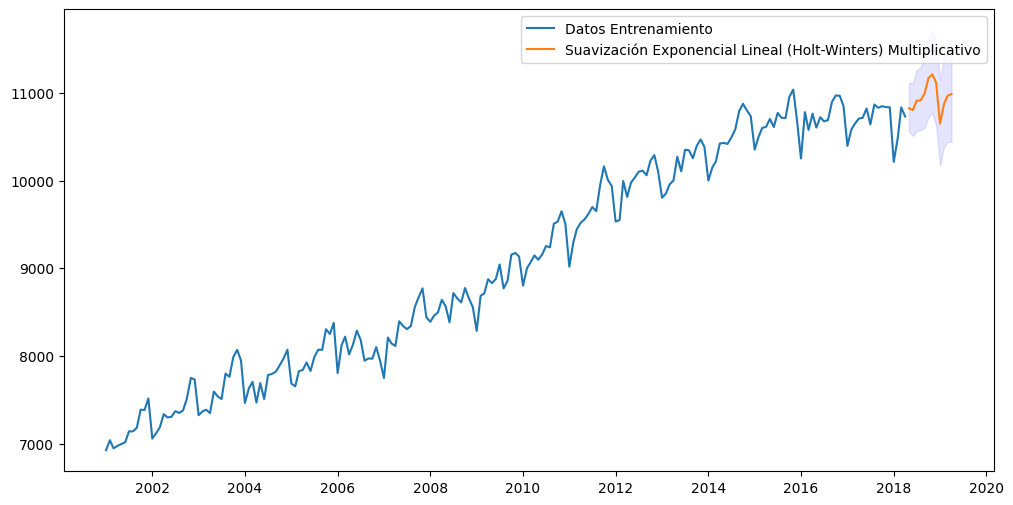

In [76]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [77]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5527464221886013 5.527464221886013e-05 4.4725357781139875e-05


In [78]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

253.93738539827106


En esta caso el α estimado es 0.5527464221886013, el β estimado es 5.527464221886013e-05 y el gamma estimado es 4.4725357781139875e-05

El RMSE en la muestra de evaluación es 253.93738539827106

# Aquí vamos, ahora a hacer los modelos y guardar los resultados

Ahora vamos a realizar los diferentes modelos para compararlos y determinar el mejor de ellos en un promedio movil de orden 6